In [81]:
import numpyro
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro.distributions as dist

from tqdm import tqdm
from jax import random
from numpyro import handlers
from numpyro.optim import Adam
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, SVI, autoguide, Trace_ELBO
from numpyro.infer.reparam import LocScaleReparam
from utils import select_columns, samples_to_df, df_to_samples, plot_ESS, plot_GR, plot_posterior

numpyro.set_platform("cpu")
numpyro.set_host_device_count(32)

num_chains = 5
num_samples = 2000
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [103]:
def model_centered(y: np.ndarray, sigma: np.ndarray):
    assert len(y) == len(sigma)
    mu = numpyro.sample("mu", dist.Normal(0, 5))
    tau = numpyro.sample("tau", dist.LogNormal(0, 5))
    with numpyro.plate("plate", len(y)):
        theta = numpyro.sample("theta", dist.Normal(mu, tau))
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

def model_noncentered(y: np.ndarray, sigma: np.ndarray):
    assert len(y) == len(sigma)
    mu_hat = numpyro.sample("mu_hat", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", mu_hat * 5)
    tau_hat = numpyro.sample("tau_hat", dist.Normal(0, 1))
    tau = numpyro.deterministic("tau", jnp.exp(tau_hat * 5))
    with numpyro.plate("plate", len(y)):
        theta_hat = numpyro.sample("theta_hat", dist.Normal(0, 1))
        theta = numpyro.deterministic("theta", mu + theta_hat * tau)
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

def model_vip(y: np.ndarray, sigma: np.ndarray):
    assert len(y) == len(sigma)
    eta = numpyro.param("eta", np.ones((3,)) / 2, constraint=dist.constraints.interval(0, 1))
    mu_hat = numpyro.sample("mu_hat", dist.Normal(0, jnp.power(5, eta[0])))
    mu = numpyro.deterministic("mu", mu_hat * jnp.power(5, 1 - eta[0]))
    tau_hat = numpyro.sample("tau_hat", dist.Normal(0, jnp.power(5, eta[1])))
    tau = numpyro.deterministic("tau", jnp.exp(tau_hat * jnp.power(5, 1 - eta[1])))
    with numpyro.plate("plate", len(y)):
        theta_hat = numpyro.sample("theta_hat", dist.Normal(mu * eta[2], jnp.power(tau, eta[2])))
        theta = numpyro.deterministic("theta", mu + (theta_hat - mu * eta[2]) * jnp.power(tau, 1 - eta[2]))
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

def model_vip_eta(y: np.ndarray, sigma: np.ndarray, eta:np.ndarray):
    assert len(y) == len(sigma)
    mu_hat = numpyro.sample("mu_hat", dist.Normal(0, jnp.power(5, eta[0])))
    mu = numpyro.deterministic("mu", mu_hat * jnp.power(5, 1 - eta[0]))
    tau_hat = numpyro.sample("tau_hat", dist.Normal(0, jnp.power(5, eta[1])))
    tau = numpyro.deterministic("tau", jnp.exp(tau_hat * jnp.power(5, 1 - eta[1])))
    with numpyro.plate("plate", len(y)):
        theta_hat = numpyro.sample("theta_hat", dist.Normal(mu * eta[2], jnp.power(tau, eta[2])))
        theta = numpyro.deterministic("theta", mu + (theta_hat - mu * eta[2]) * jnp.power(tau, 1 - eta[2]))
        numpyro.sample("obs", dist.Normal(theta, sigma), obs=y)

def guide_vip(y: np.ndarray, sigma: np.ndarray):
    mean_mu = numpyro.param("mean_mu", 0.0)
    sigma_mu = numpyro.param("sigma_mu", 1.0, constraint=dist.constraints.positive)
    mu_hat = numpyro.sample("mu_hat", dist.Normal(mean_mu, sigma_mu))
    
    mean_tau = numpyro.param("mean_tau", 0.0)
    sigma_tau = numpyro.param("sigma_tau", 1.0, constraint=dist.constraints.positive)
    tau_hat = numpyro.sample("tau_hat", dist.Normal(mean_tau, sigma_tau))

    with numpyro.plate("plate", len(y)):
        mean_theta = numpyro.param("mean_theta", 0.0)
        sigma_theta = numpyro.param("sigma_theta", 1.0, constraint=dist.constraints.positive)
        theta_hat = numpyro.sample("theta_hat", dist.Normal(mean_theta, sigma_theta))

loss: 33.663291931152344: 100%|██████████| 1000/1000 [00:59<00:00, 16.78it/s]


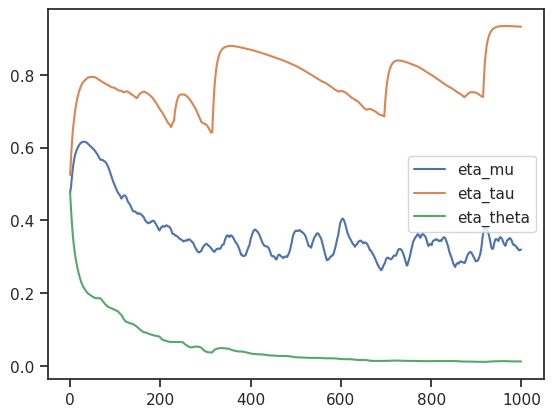

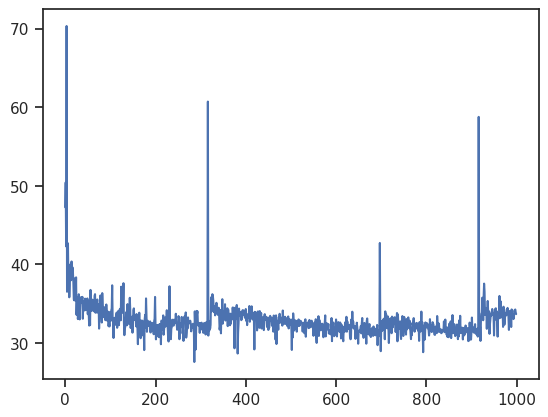

In [101]:
n_epochs = 1000
adam = Adam(0.1)
svi = SVI(model_vip, guide_vip, adam, Trace_ELBO())
svi_state = svi.init(random.PRNGKey(0), y, sigma)
train_loader = tqdm(range(n_epochs), total=n_epochs)
etas = []
losses = []
for _ in train_loader:
    svi_state, loss = svi.update(svi_state, y, sigma)
    train_loader.set_description(f"loss: {loss.item()}")
    etas.append(svi.get_params(svi_state)["eta"])
    losses.append(loss.item())

plt.plot(np.stack(etas), label=("eta_mu", "eta_tau", "eta_theta"))
plt.legend()
plt.show()

plt.plot(np.stack(losses))
plt.show()

In [105]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model_centered)
mcmc = MCMC(kernel, num_warmup=num_samples, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, y=y, sigma=sigma)
mcmc.print_summary()
samples_centered = mcmc.get_samples()
df_centered = samples_to_df(samples_centered)
df_centered.to_csv("result/eight_school_centered.csv")

kernel = NUTS(model_noncentered)
mcmc = MCMC(kernel, num_warmup=num_samples, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, y=y, sigma=sigma)
mcmc.print_summary(exclude_deterministic=False)
samples_noncentered = mcmc.get_samples()
df_noncentered = samples_to_df(samples_noncentered)
df_noncentered.to_csv("result/eight_school_noncentered.csv")

kernel = NUTS(model_vip_eta)
mcmc = MCMC(kernel, num_warmup=num_samples, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, y=y, sigma=sigma, eta=etas[-1])
mcmc.print_summary(exclude_deterministic=False)
samples_vip = mcmc.get_samples()
df_vip = samples_to_df(samples_vip)
df_vip.to_csv("result/eight_school_vip.csv")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.34      3.36      4.38     -1.33      9.96    341.44      1.01
       tau      2.30      2.99      1.12      0.12      6.07    299.42      1.02
  theta[0]      5.39      4.88      5.03     -2.29     12.11    573.48      1.00
  theta[1]      4.65      4.28      4.58     -2.05     11.40    529.32      1.00
  theta[2]      4.10      4.61      4.22     -2.70     11.19    633.87      1.00
  theta[3]      4.57      4.28      4.57     -2.26     11.21    550.15      1.00
  theta[4]      3.90      4.22      4.12     -2.77     10.62    530.85      1.00
  theta[5]      4.09      4.34      4.23     -2.56     11.09    526.67      1.00
  theta[6]      5.39      4.47      5.06     -1.74     12.06    501.63      1.01
  theta[7]      4.63      4.57      4.57     -2.65     11.27    659.29      1.00

Number of divergences: 519


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          mu      4.54      3.17      4.54     -0.53      9.86   7411.28      1.00
      mu_hat      0.91      0.63      0.91     -0.11      1.97   7411.28      1.00
         tau      1.04      2.27      0.11      0.00      3.25   4006.51      1.00
     tau_hat     -0.56      0.69     -0.44     -1.55      0.49   4310.11      1.00
    theta[0]      5.04      4.03      4.80     -1.17     10.68   5443.46      1.00
    theta[1]      4.65      3.64      4.62     -1.19     10.31   6533.22      1.00
    theta[2]      4.39      3.79      4.50     -1.43     10.36   6519.14      1.00
    theta[3]      4.64      3.67      4.60     -1.03     10.55   6287.60      1.00
    theta[4]      4.34      3.65      4.43     -1.11     10.37   6501.02      1.00
    theta[5]      4.44      3.69      4.49     -1.07     10.40   5556.88      1.00
    theta[6]      4.97      3.81      4.80     -1.10     10.67   6023.37      1.00
   

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          mu      4.54      3.23      4.60     -0.82      9.80   7207.16      1.00
      mu_hat      1.52      1.08      1.54     -0.28      3.28   7207.16      1.00
         tau      1.05      2.30      0.11      0.00      3.31   3656.97      1.00
     tau_hat     -2.49      3.05     -2.02     -6.97      2.13   3960.61      1.00
    theta[0]      4.98      3.97      4.81     -1.88     10.35   6042.92      1.00
    theta[1]      4.64      3.68      4.65     -1.24     10.52   6930.35      1.00
    theta[2]      4.36      3.89      4.51     -1.63     10.36   5894.64      1.00
    theta[3]      4.63      3.70      4.66     -1.36     10.51   6778.43      1.00
    theta[4]      4.32      3.66      4.45     -1.45     10.38   6254.56      1.00
    theta[5]      4.46      3.62      4.54     -0.87     10.76   6890.72      1.00
    theta[6]      5.05      3.93      4.84     -1.08     10.94   6150.70      1.00
   

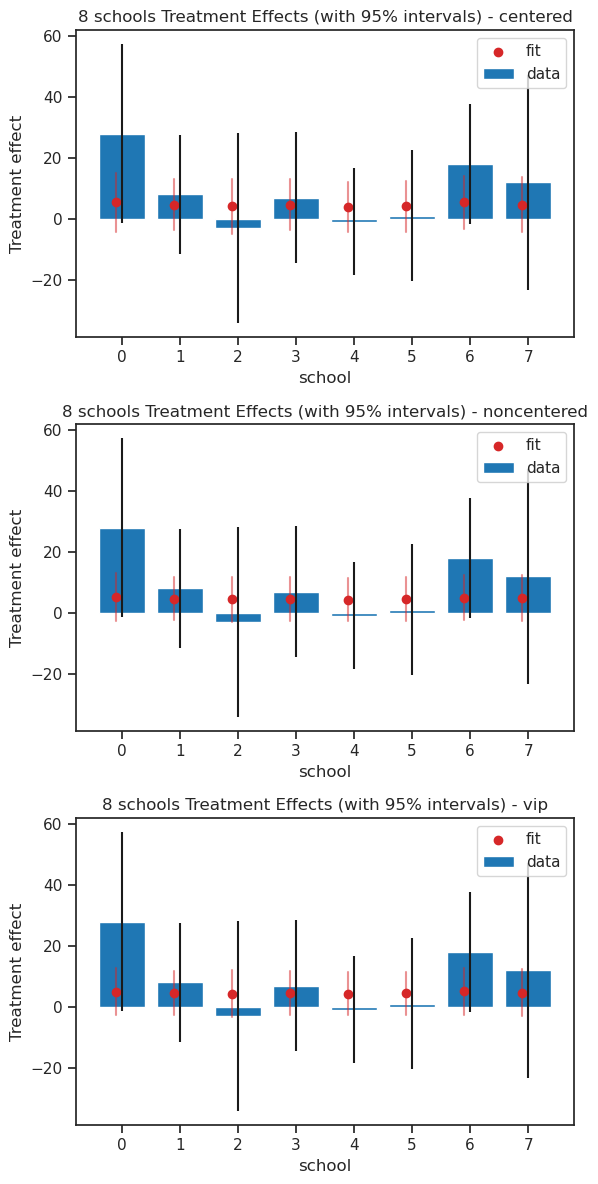

In [106]:
df_centered = pd.read_csv("result/eight_school_centered.csv")
df_noncentered = pd.read_csv("result/eight_school_noncentered.csv")
df_vip = pd.read_csv("result/eight_school_vip.csv")
dfs = [df_centered, df_noncentered, df_vip]
labels = ["centered", "noncentered", "vip"]

fig, axes = plt.subplots(len(dfs), 1, figsize=(6, 12))
for i, df, label in zip(range(3), dfs, labels):
    theta = select_columns(df, "theta")
    mean = theta.mean(axis=0)
    std = theta.std(axis=0)
    axes[i].bar(np.arange(0, len(y)), y, color="tab:blue", yerr=1.96 * sigma, label="data")
    axes[i].scatter(np.arange(0, len(y)) - 0.1, mean, color="tab:red", label="fit")
    for x, (ymin, ymax) in enumerate(zip(mean - 1.96 * std, mean + 1.96 * std)):
        axes[i].plot([x - 0.1, x - 0.1], [ymin, ymax], color="tab:red", alpha=0.5)
    axes[i].set_title(f"8 schools Treatment Effects (with 95% intervals) - {label}")
    axes[i].set_ylabel("Treatment effect")
    axes[i].set_xlabel("school")
    axes[i].legend()

plt.tight_layout()
plt.show()

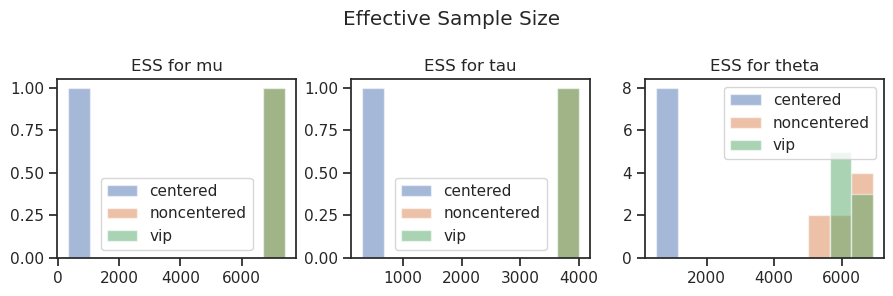

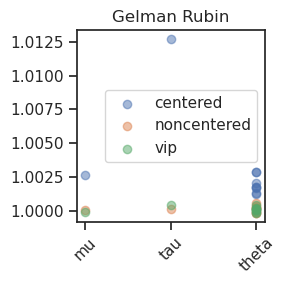

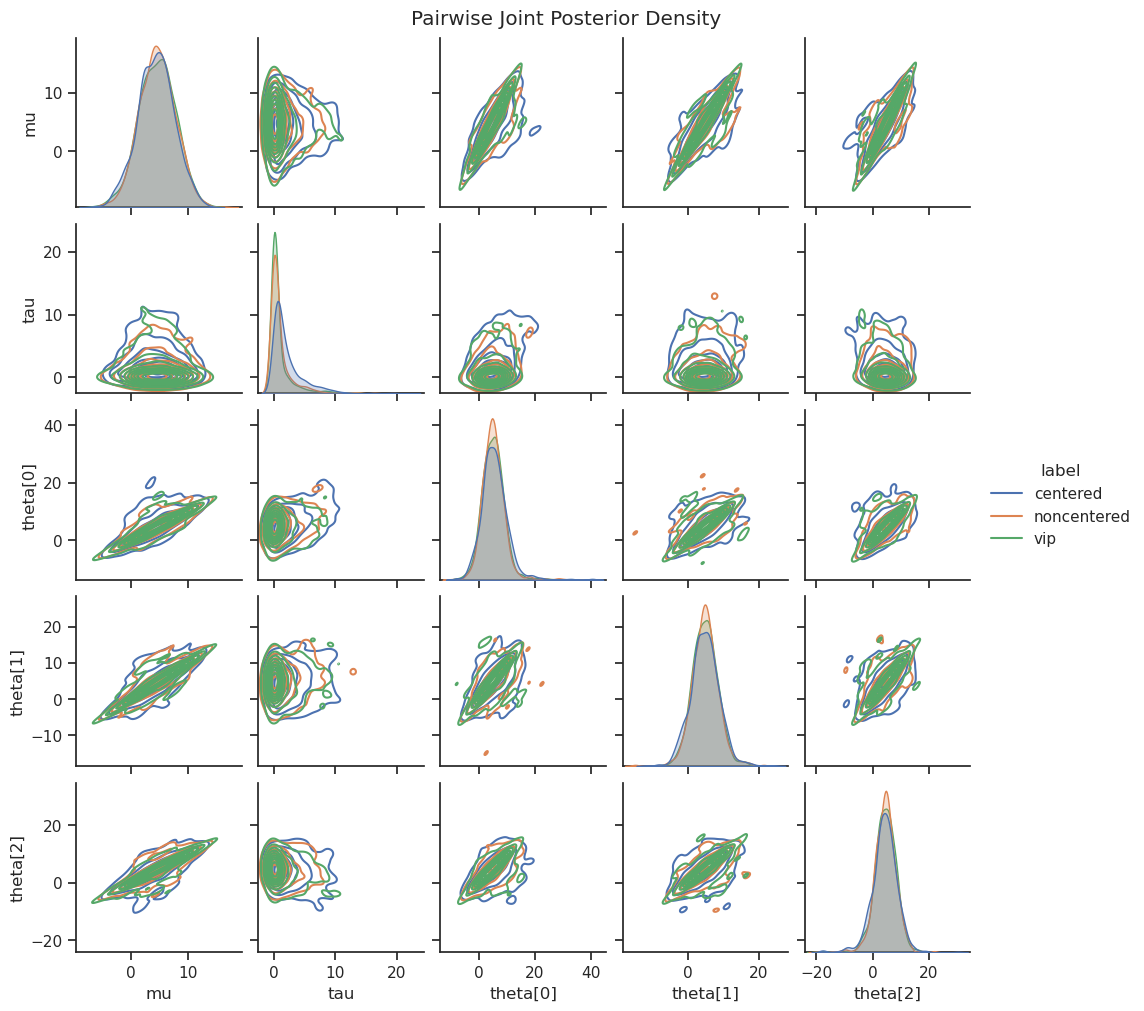

In [107]:
plot_ESS(dfs, labels,
         params=["mu", "tau", "theta"],
         num_chains=num_chains, num_samples=num_samples)

plot_GR(dfs, labels,
        params=["mu", "tau", "theta"],
        num_chains=num_chains, num_samples=num_samples)

plot_posterior(dfs, labels,
               params=["mu", "tau", "theta[0]", "theta[1]", "theta[2]"],
               num_subsamples=1000)

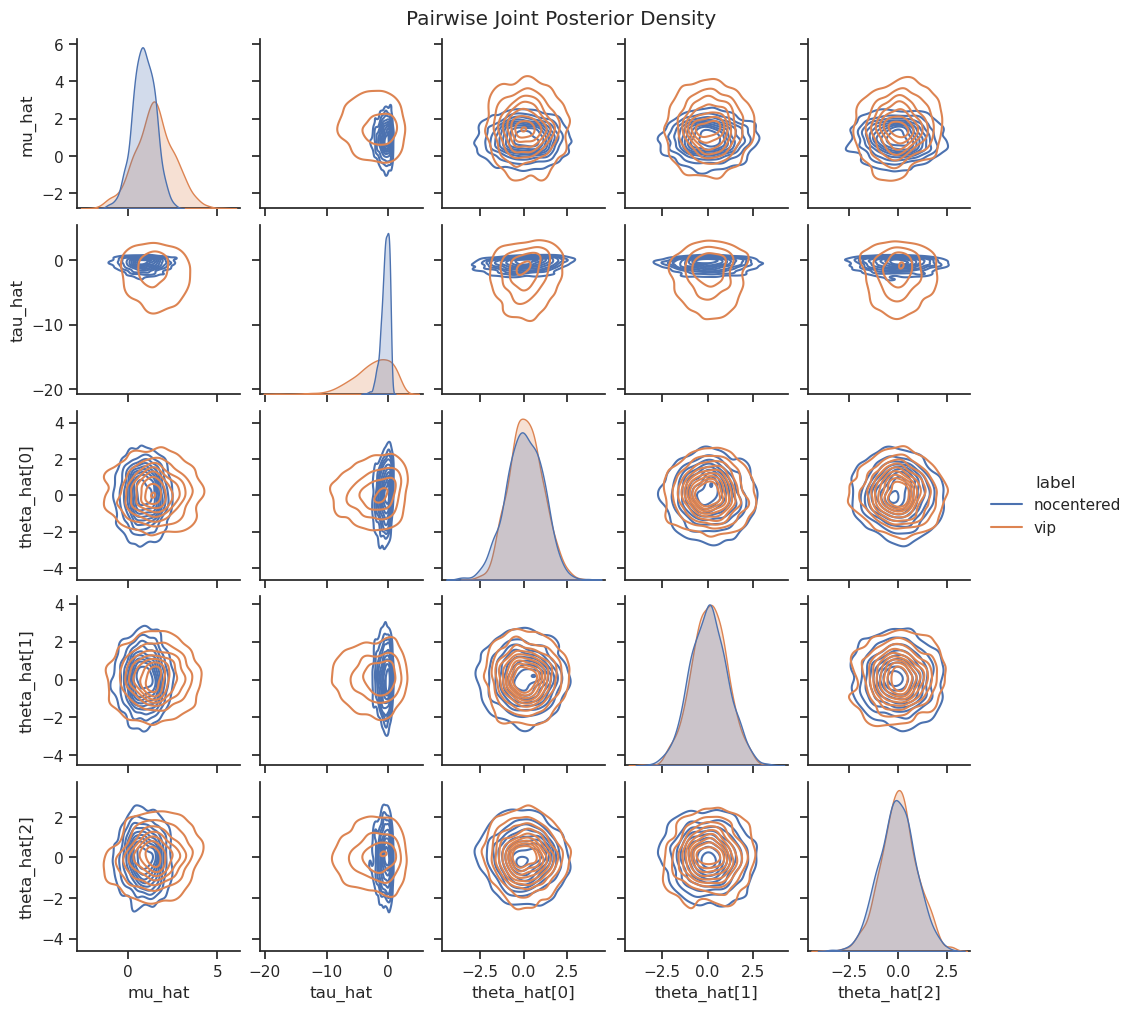

In [108]:
plot_posterior(dfs=[df_noncentered, df_vip], labels=["nocentered", "vip"],
               params=["mu_hat", "tau_hat", "theta_hat[0]", "theta_hat[1]", "theta_hat[2]"],
               num_subsamples=1000)